In [133]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRegressor


In [136]:

#Выгрузка данных - таблица с результатами ГИС (вставьте свою директорию)
filepath = '/Users/aleksandrbogdanov/MyJupyterNotebook/Logs.xlsx'
data = pd.read_excel(filepath)

# Ниже я просто решил поучиться преобразовывать таблицу в удобный вид. Можно было использовать эксель, но решил использовать функционал pandas


#Удаляем ненужный стобец
df = data.drop(data.columns[0], axis = 1)

#Преобразуем таблицу pandas в рабочий вид. Устанавливаем названия стобцов

col = np.array(df.iloc[0])
df.columns = col
df = df[1:]

df

,Depth,AK,BK,DS,GGKp,GK,GZ1,GZ2,GZ3,GZ4,GZ5,GZ7,IK,MGZ,MPZ,MRES,NGK,PS,PZ,W
1,2790,280.79,7.78,220.058,2.512,10.453,12,11.52,8.78,7.22,6.26,8.95,96,8.515,4.93,1.941,2.371,124.366,10.82,-99999.0
2,2790.2,280.629,7.86,220.55,2.46,11.234,12.32,11.42,8.5,7.22,6.04,9.1,97,8.418,4.77,1.942,2.403,124.216,10.69,-99999.0
3,2790.4,281.805,7.78,220.182,2.405,11.061,12.02,11.2,8.02,6.94,5.8,9,97,8.038,4.79,1.944,2.425,124.142,10.82,-99999.0
4,2790.6,280.283,7.86,220.187,2.46,9.906,12,10.62,7.54,6.67,5.58,8.69,96,7.872,4.65,1.942,2.416,124.777,10.89,-99999.0
5,2790.8,279.355,7.63,219.342,2.493,9.465,10.83,10.72,7.4,6.51,5.46,8.49,94,7.371,4.54,1.945,2.397,124.59,10.84,-99999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,2907,261.106,11.32,206.309,2.474,6.809,9.73,10.48,12.72,2.32,0.49,10.66,74,11.798,7.31,1.972,3.24,128.666,15.97,0.244
561,2907.2,262.17,11.84,206.518,2.466,7.11,10.01,11.44,15,2.1,0.56,12.28,78,11.566,7.36,1.965,3.401,128.928,16.32,0.22
562,2907.4,258.656,12.67,206.443,2.449,7.116,11.01,12.24,16.93,2.1,0.49,13.89,81,11.039,7.61,1.956,3.375,128.442,17.11,0.224
563,2907.6,258.36,13.04,206.433,2.497,7.328,11.23,13.39,18.52,2.38,0.49,15.91,88,13.736,8.93,1.958,3.295,128.442,18.34,0.236


In [89]:
#Удаляем стобец глубина и водородосодержание - непоказательные.

df = df.drop(['W'], axis=1)
#df = df.drop(['AK', 'BK', 'GZ1', 'GZ2', 'GZ3', 'GZ5', 'GZ4', 'GZ7', 'MGZ', 'MPZ', 'DS', 'MRES','PZ'], axis = 1)


Data analysis

In [84]:
# Посмотрим на наличие пропусков

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564 entries, 1 to 564
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Depth   564 non-null    object
 1   AK      564 non-null    object
 2   BK      564 non-null    object
 3   DS      564 non-null    object
 4   GGKp    564 non-null    object
 5   GK      564 non-null    object
 6   GZ1     564 non-null    object
 7   GZ2     564 non-null    object
 8   GZ3     564 non-null    object
 9   GZ4     564 non-null    object
 10  GZ5     564 non-null    object
 11  GZ7     564 non-null    object
 12  IK      564 non-null    object
 13  MGZ     564 non-null    object
 14  MPZ     564 non-null    object
 15  MRES    564 non-null    object
 16  NGK     564 non-null    object
 17  PS      564 non-null    object
 18  PZ      564 non-null    object
dtypes: object(19)
memory usage: 83.8+ KB


In [90]:
# Переведем из типа object в float

df = df.astype('float64')

<Axes: >

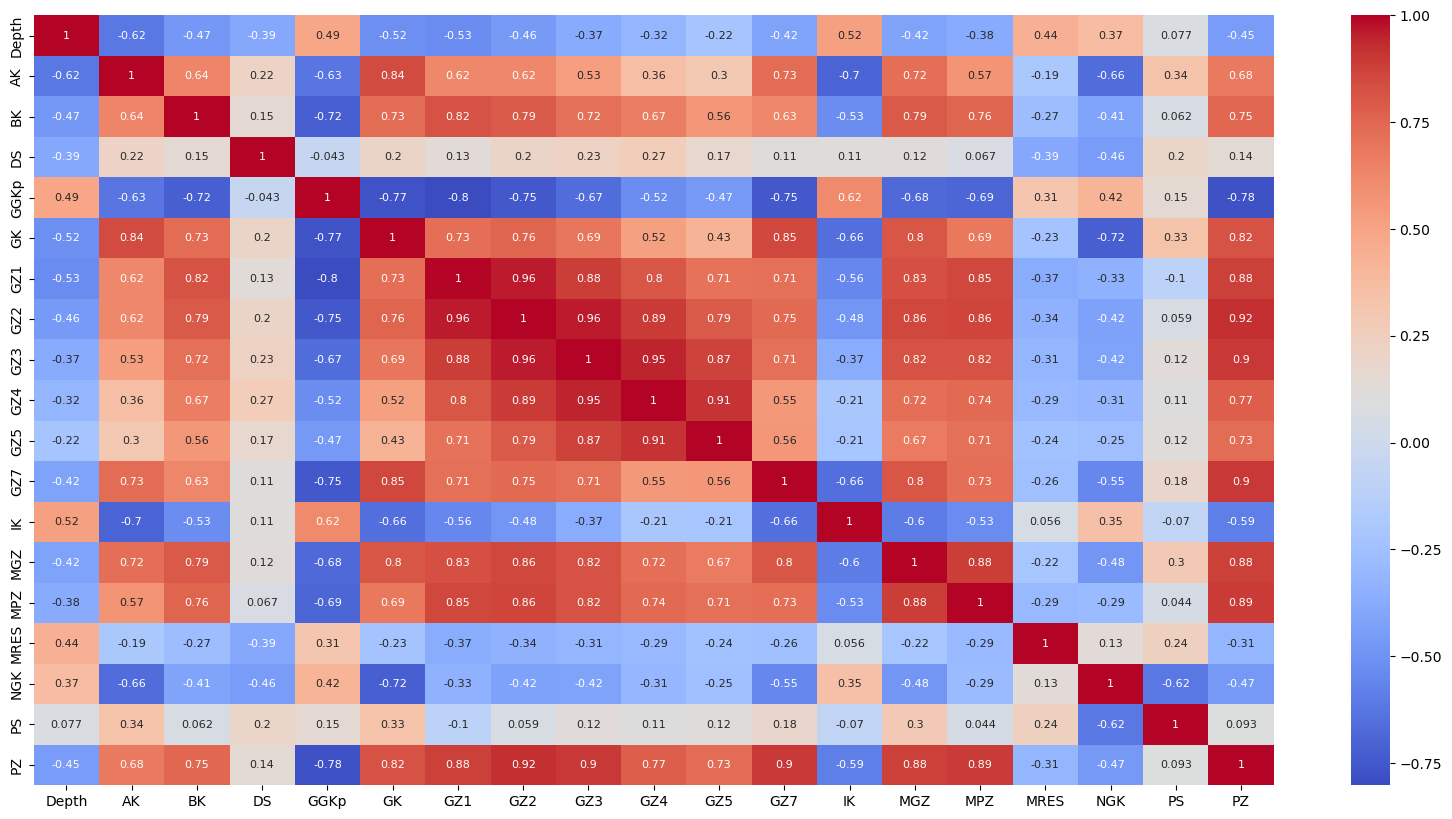

In [91]:
# Пропусков нет, посмотрим корреляцию признаков. Target - NGK

corr = df.corr()

plt.figure(figsize=(20, 10))

sns.heatmap(corr, cmap='coolwarm', annot=True, annot_kws={'fontsize':8})




<Axes: >

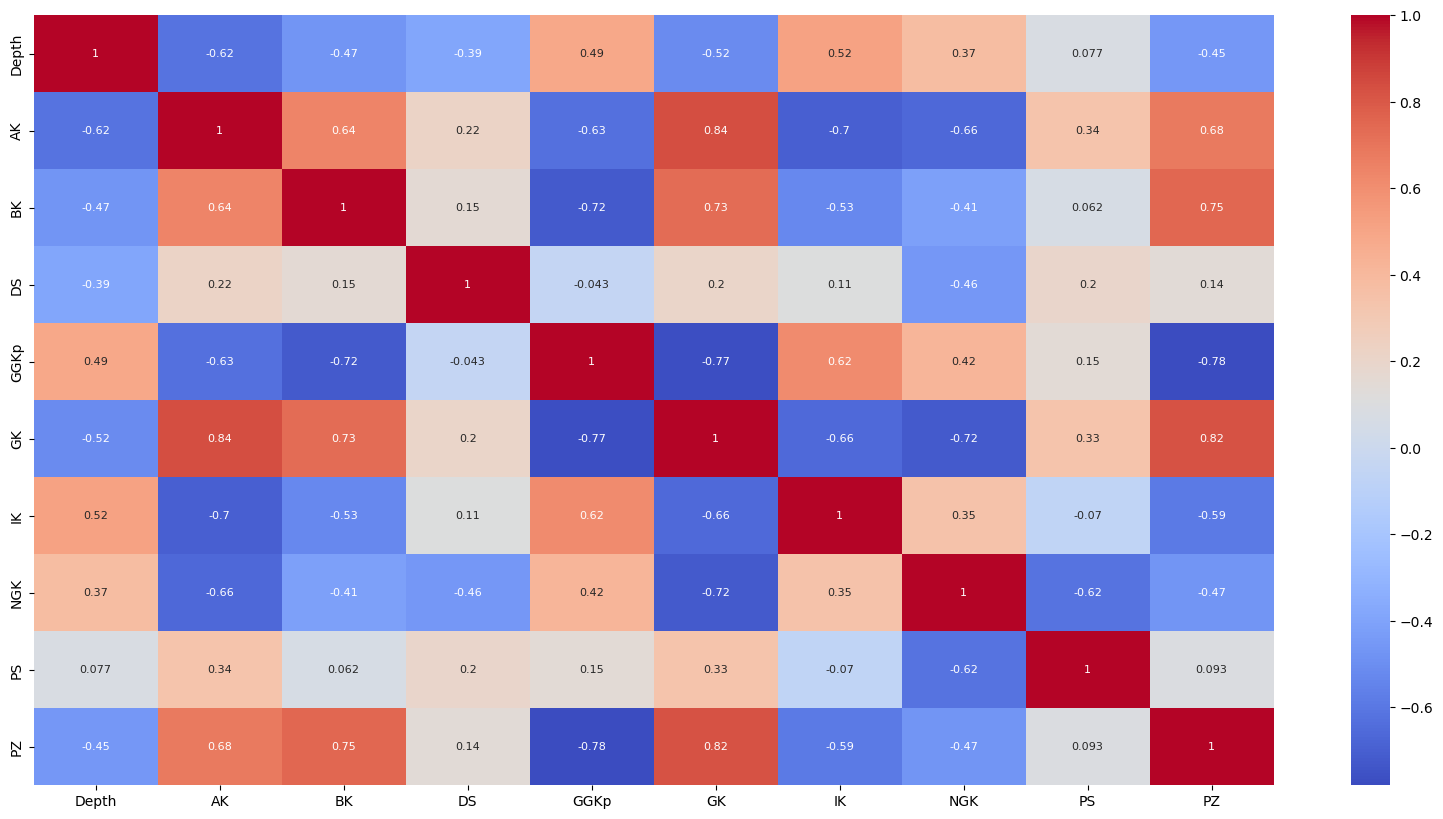

In [92]:
# Вследствие мультиколиннеарности удалим сильно коррелирующие признаки

df.drop(['GZ1', 'GZ2', 'GZ3', 'GZ5', 'GZ4', 'GZ7', 'MPZ', 'MGZ', 'MRES'], axis=1, inplace=True)

corr = df.corr()

plt.figure(figsize=(20, 10))

sns.heatmap(corr, cmap='coolwarm', annot=True, annot_kws={'fontsize':8})

In [ ]:
# Проверять на наличие выбросов не будем! В разрезе скважины есть толща с аномальными характеристиками
# несущая важную геологическую информацию - Баженовская нефтематеринская толща

Построение модели

In [109]:
X = df.drop(['NGK'], axis = 1)
y = df['NGK']

# Массив name для дальнейшего использования feature_importances
name_1 = df.drop(['NGK', 'Depth'], axis=1)
names = name_1.columns.to_list()


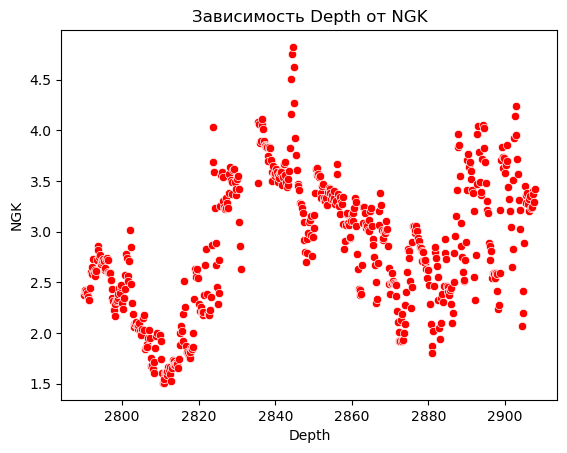

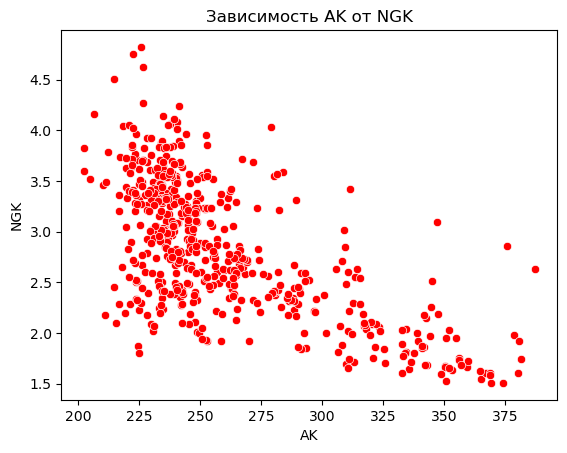

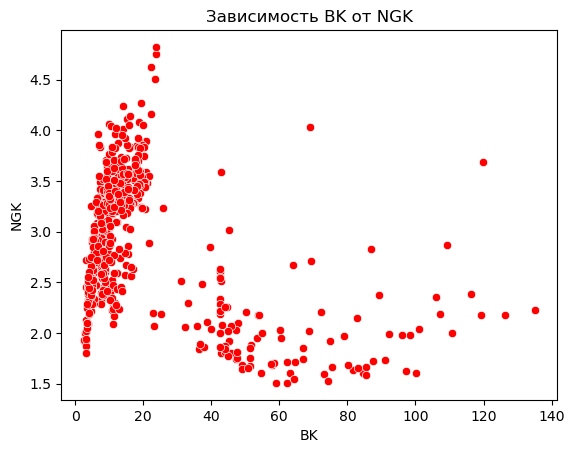

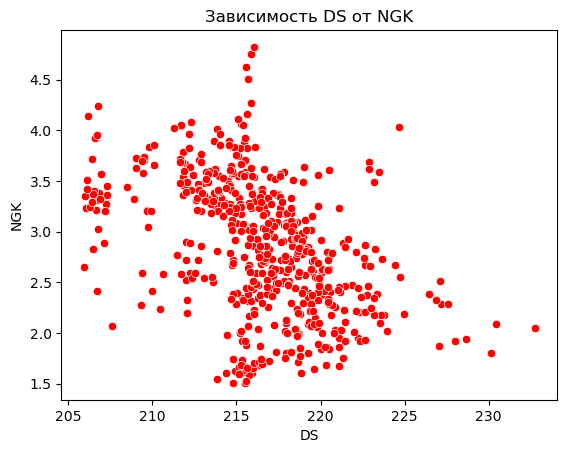

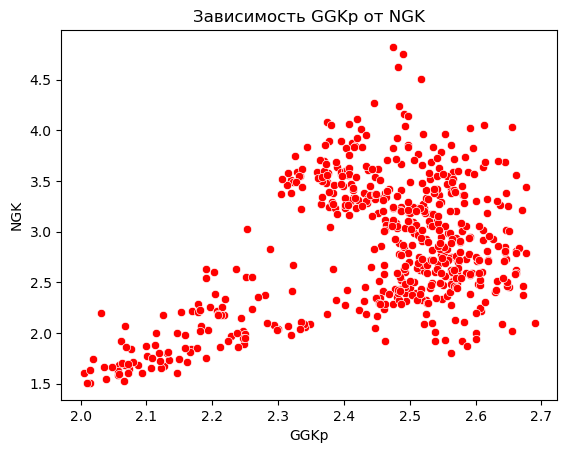

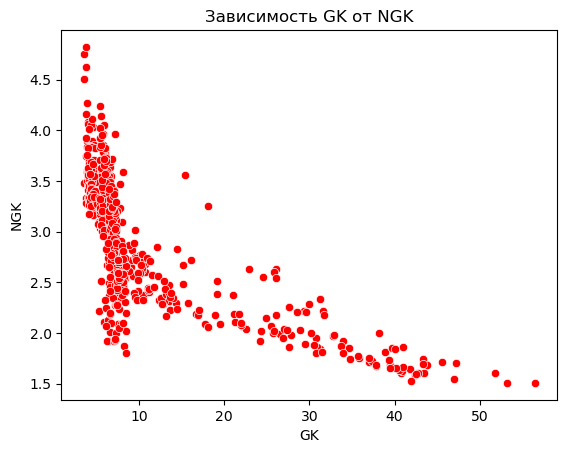

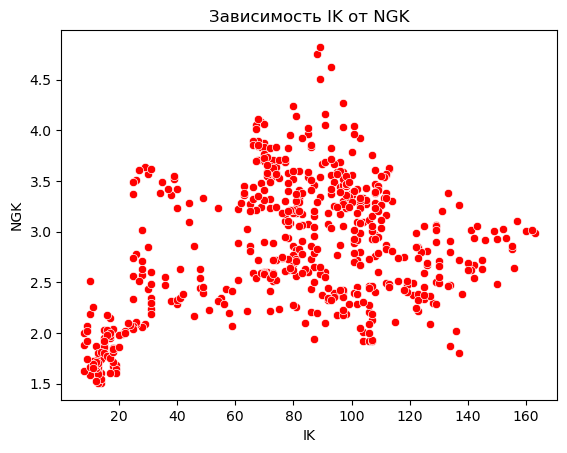

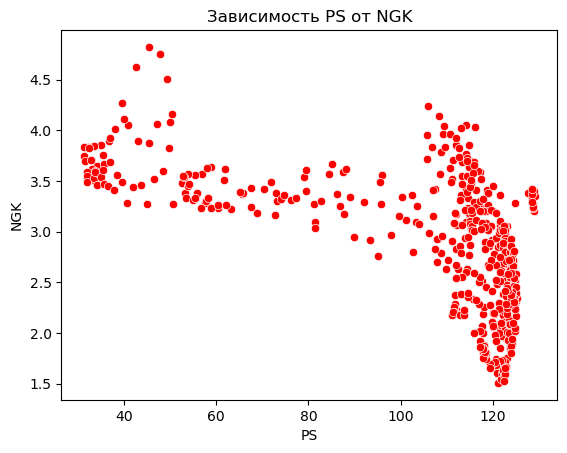

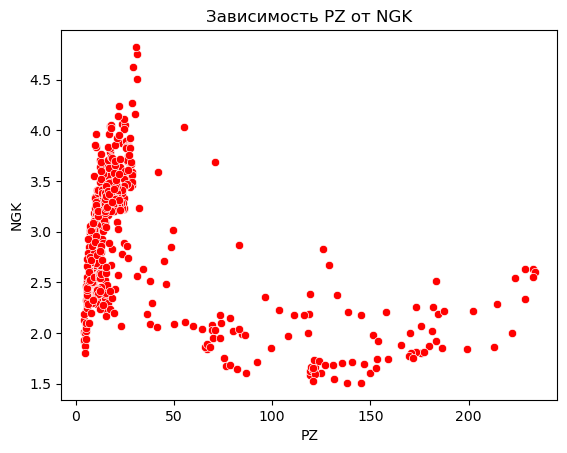

In [100]:
for col in X.columns:
    sns.scatterplot(x = X[col], y = y, color = 'r')
    plt.title(f'Зависимость {col} от NGK')
    plt.show()

In [ ]:
# Видно, что зависимость нелинейная, попробуем использовать алгоритмы, построенные на деревьях для прогноза NGK

In [101]:

np.random.seed(42)

#Делим на тест и трейн первый раз - достанем тестовую глубину
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

# Берем глубину для визуализации предсказаний каротажа
depth = X_test.loc[:, 'Depth']
X = X.drop('Depth', axis=1)

#Делим на тест и трейн
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [102]:
# Используем optuna и cross-валидацию для подбора гиперпараметров

def objective_GB(trial):
    
    max_depth = trial.suggest_int('max_depth', 2, 15, step = 3)
    n_estimators = trial.suggest_int('n_estimators', 10, 1000, 20)
    max_features = trial.suggest_categorical('max_features', [None, 'sqrt', 'log2'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log = True)
    
    score = cross_val_score(GradientBoostingRegressor(max_depth=max_depth, n_estimators=n_estimators,
                                                     max_features=max_features, learning_rate=learning_rate,
                                                     random_state=42),
                           X_train, y_train, cv=3, scoring='r2', n_jobs=-1).mean()
    return score

In [103]:
# Подбираем гиперпараметры

study_gb = optuna.create_study(direction='maximize')
study_gb.optimize(objective_GB, n_trials=30)
study_gb.best_params

[I 2024-04-10 21:37:02,305] A new study created in memory with name: no-name-82241a3f-739c-4467-9e85-c0c115543be0
/Users/aleksandrbogdanov/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [2, 15] and step=3, but the range is not divisible by `step`. It will be replaced by [2, 14].
  warnings.warn(
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_23100/2490683891.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int('n_estimators', 10, 1000, 20)
/Users/aleksandrbogdanov/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [10, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 990].
  warnings.warn(
[I 2024-04-10 21:37:04,403] Trial 0 finished with value: 0.3713536470551035 and parameters: {'max_depth': 11, 

{'max_depth': 14,
 'n_estimators': 610,
 'max_features': 'log2',
 'learning_rate': 0.01004692266144022}

In [104]:
# Обучаем модель с найденными гиперпараметрами

model_gb_optuna = GradientBoostingRegressor(**study_gb.best_params)
model_gb_optuna.fit(X_train, y_train)
preds_gb_optuna = model_gb_optuna.predict(X_test)
r2_score(y_test, preds_gb_optuna)

0.9309777751868691

In [26]:
# Сначала используем модель классического град бустинга - подберем гиперпараметры GridSearch

# Сначала подберем два основных гиперпараметра для ансамблей - количество базовых деревьев и макс глубина
params = {'max_depth': np.arange(3,15,3),
         'n_estimators': np.arange(10, 300, 10)}

gb_gs = GridSearchCV(GradientBoostingRegressor(random_state=42), params, cv=3, scoring='r2', verbose=2)
gb_gs.fit(X_train, y_train)

gb_gs.best_score_, gb_gs.best_estimator_




Fitting 3 folds for each of 116 candidates, totalling 348 fits
[CV] END .......................max_depth=3, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=3, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=3, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=3, n_estimators=20; total time=   0.0s
[CV] END .......................max_depth=3, n_estimators=20; total time=   0.0s
[CV] END .......................max_depth=3, n_estimators=20; total time=   0.0s
[CV] END .......................max_depth=3, n_estimators=30; total time=   0.0s
[CV] END .......................max_depth=3, n_estimators=30; total time=   0.0s
[CV] END .......................max_depth=3, n_estimators=30; total time=   0.0s
[CV] END .......................max_depth=3, n_estimators=40; total time=   0.0s
[CV] END .......................max_depth=3, n_estimators=40; total time=   0.0s
[CV] END .......................max_depth=3, n

[CV] END .......................max_depth=6, n_estimators=50; total time=   0.1s
[CV] END .......................max_depth=6, n_estimators=60; total time=   0.1s
[CV] END .......................max_depth=6, n_estimators=60; total time=   0.1s
[CV] END .......................max_depth=6, n_estimators=60; total time=   0.1s
[CV] END .......................max_depth=6, n_estimators=70; total time=   0.1s
[CV] END .......................max_depth=6, n_estimators=70; total time=   0.1s
[CV] END .......................max_depth=6, n_estimators=70; total time=   0.1s
[CV] END .......................max_depth=6, n_estimators=80; total time=   0.1s
[CV] END .......................max_depth=6, n_estimators=80; total time=   0.1s
[CV] END .......................max_depth=6, n_estimators=80; total time=   0.1s
[CV] END .......................max_depth=6, n_estimators=90; total time=   0.1s
[CV] END .......................max_depth=6, n_estimators=90; total time=   0.1s
[CV] END ...................

[CV] END ......................max_depth=9, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=9, n_estimators=110; total time=   0.2s
[CV] END ......................max_depth=9, n_estimators=110; total time=   0.2s
[CV] END ......................max_depth=9, n_estimators=110; total time=   0.2s
[CV] END ......................max_depth=9, n_estimators=120; total time=   0.3s
[CV] END ......................max_depth=9, n_estimators=120; total time=   0.3s
[CV] END ......................max_depth=9, n_estimators=120; total time=   0.3s
[CV] END ......................max_depth=9, n_estimators=130; total time=   0.3s
[CV] END ......................max_depth=9, n_estimators=130; total time=   0.3s
[CV] END ......................max_depth=9, n_estimators=130; total time=   0.3s
[CV] END ......................max_depth=9, n_estimators=140; total time=   0.3s
[CV] END ......................max_depth=9, n_estimators=140; total time=   0.3s
[CV] END ...................

[CV] END .....................max_depth=12, n_estimators=150; total time=   0.4s
[CV] END .....................max_depth=12, n_estimators=160; total time=   0.4s
[CV] END .....................max_depth=12, n_estimators=160; total time=   0.4s
[CV] END .....................max_depth=12, n_estimators=160; total time=   0.4s
[CV] END .....................max_depth=12, n_estimators=170; total time=   0.4s
[CV] END .....................max_depth=12, n_estimators=170; total time=   0.4s
[CV] END .....................max_depth=12, n_estimators=170; total time=   0.4s
[CV] END .....................max_depth=12, n_estimators=180; total time=   0.4s
[CV] END .....................max_depth=12, n_estimators=180; total time=   0.4s
[CV] END .....................max_depth=12, n_estimators=180; total time=   0.4s
[CV] END .....................max_depth=12, n_estimators=190; total time=   0.4s
[CV] END .....................max_depth=12, n_estimators=190; total time=   0.4s
[CV] END ...................

(0.9023309095156579,
 GradientBoostingRegressor(n_estimators=290, random_state=42))

In [37]:
# Поберем еще два важный гиперпараметра - max_features - количество признаков, отбираемых для построения предиката
# Из исходного множества признаков
# И learning_rate - шаг градиентного спуска

params_2 = {'max_features': [None, 'log2', 'sqrt'],
           'learning_rate': [0.0001, 0.001, 0.01, 0.1]}

gb_gs_2 = GridSearchCV(GradientBoostingRegressor(**gb_gs.best_params_), params_2, cv=3, scoring='r2', verbose=2)
gb_gs_2.fit(X_train, y_train)

gb_gs_2.best_score_, gb_gs_2.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ............learning_rate=0.0001, max_features=None; total time=   0.3s
[CV] END ............learning_rate=0.0001, max_features=None; total time=   0.3s
[CV] END ............learning_rate=0.0001, max_features=None; total time=   0.3s
[CV] END ............learning_rate=0.0001, max_features=log2; total time=   0.1s
[CV] END ............learning_rate=0.0001, max_features=log2; total time=   0.1s
[CV] END ............learning_rate=0.0001, max_features=log2; total time=   0.1s
[CV] END ............learning_rate=0.0001, max_features=sqrt; total time=   0.1s
[CV] END ............learning_rate=0.0001, max_features=sqrt; total time=   0.1s
[CV] END ............learning_rate=0.0001, max_features=sqrt; total time=   0.1s
[CV] END .............learning_rate=0.001, max_features=None; total time=   0.3s
[CV] END .............learning_rate=0.001, max_features=None; total time=   0.3s
[CV] END .............learning_rate=0.001, max_f

(0.9081234444267384,
 GradientBoostingRegressor(max_features='log2', n_estimators=290))

In [38]:
# Обучим модель

model_gb_grid_s = GradientBoostingRegressor(**gb_gs_2.best_params_)
model_gb_grid_s.fit(X_train, y_train)

preds_gb_grid_s = model_gb_grid_s.predict(X_test)
print(r2_score(y_test, preds_gb_grid_s))

0.9216840878192623


In [54]:
y_test

538    3.925
523    3.633
235    3.463
524    3.736
486    2.554
       ...  
421    2.691
382    2.488
519    2.589
404    2.453
115    1.725
Name: NGK, Length: 170, dtype: object

In [105]:
# Отсортируем полученные значения по optuna для визуализации предсказаний

depth_values = depth.values.astype('float64')
y_test_for_plot = y_test.values.astype('float64')

plot_test_arr = list(zip(depth_values, y_test_for_plot))
plot_sorted_arr = sorted(plot_test_arr, key=lambda x: x[0])
depth_plotting = [i[0] for i in plot_sorted_arr]
y_test_plotting = [i[1] for i in plot_sorted_arr]
depth_plotting


[2790.0,
 2790.4,
 2791.2,
 2791.8,
 2792.0,
 2792.2,
 2793.0,
 2793.6,
 2794.4,
 2796.0,
 2796.6,
 2797.8,
 2799.2,
 2800.8,
 2801.0,
 2802.6,
 2803.6,
 2803.8,
 2804.0,
 2804.4,
 2804.6,
 2805.0,
 2805.2,
 2805.4,
 2805.6,
 2805.8,
 2806.2,
 2806.4,
 2806.6,
 2806.8,
 2807.2,
 2807.6,
 2807.8,
 2808.0,
 2808.6,
 2810.8,
 2811.4,
 2812.2,
 2812.4,
 2813.4,
 2814.0,
 2814.2,
 2815.4,
 2816.8,
 2817.0,
 2818.0,
 2818.6,
 2819.4,
 2819.6,
 2820.2,
 2820.4,
 2821.2,
 2821.6,
 2822.4,
 2823.4,
 2823.8,
 2824.2,
 2826.0,
 2826.2,
 2827.2,
 2827.6,
 2827.8,
 2828.4,
 2829.2,
 2829.8,
 2830.6,
 2835.6,
 2835.8,
 2836.6,
 2836.8,
 2837.0,
 2837.2,
 2838.6,
 2839.4,
 2840.6,
 2841.2,
 2841.8,
 2842.6,
 2844.4,
 2844.6,
 2844.8,
 2845.0,
 2846.0,
 2846.4,
 2847.2,
 2847.6,
 2848.0,
 2849.2,
 2850.0,
 2851.0,
 2852.2,
 2853.0,
 2853.2,
 2854.2,
 2857.0,
 2857.2,
 2858.2,
 2858.6,
 2859.2,
 2859.4,
 2859.8,
 2860.6,
 2860.8,
 2861.2,
 2861.8,
 2862.2,
 2862.6,
 2863.0,
 2864.8,
 2865.4,
 2865.6,
 

In [106]:
# Тут непосредственно предсказания

plot_preds_arr = list(zip(depth_values, preds_gb_optuna))
plot_sorted_preds = sorted(plot_preds_arr, key=lambda x: x[0])
depth_plotting = [i[0] for i in plot_sorted_preds]
preds_plotting = [i[1] for i in plot_sorted_preds]
depth_plotting

[2790.0,
 2790.4,
 2791.2,
 2791.8,
 2792.0,
 2792.2,
 2793.0,
 2793.6,
 2794.4,
 2796.0,
 2796.6,
 2797.8,
 2799.2,
 2800.8,
 2801.0,
 2802.6,
 2803.6,
 2803.8,
 2804.0,
 2804.4,
 2804.6,
 2805.0,
 2805.2,
 2805.4,
 2805.6,
 2805.8,
 2806.2,
 2806.4,
 2806.6,
 2806.8,
 2807.2,
 2807.6,
 2807.8,
 2808.0,
 2808.6,
 2810.8,
 2811.4,
 2812.2,
 2812.4,
 2813.4,
 2814.0,
 2814.2,
 2815.4,
 2816.8,
 2817.0,
 2818.0,
 2818.6,
 2819.4,
 2819.6,
 2820.2,
 2820.4,
 2821.2,
 2821.6,
 2822.4,
 2823.4,
 2823.8,
 2824.2,
 2826.0,
 2826.2,
 2827.2,
 2827.6,
 2827.8,
 2828.4,
 2829.2,
 2829.8,
 2830.6,
 2835.6,
 2835.8,
 2836.6,
 2836.8,
 2837.0,
 2837.2,
 2838.6,
 2839.4,
 2840.6,
 2841.2,
 2841.8,
 2842.6,
 2844.4,
 2844.6,
 2844.8,
 2845.0,
 2846.0,
 2846.4,
 2847.2,
 2847.6,
 2848.0,
 2849.2,
 2850.0,
 2851.0,
 2852.2,
 2853.0,
 2853.2,
 2854.2,
 2857.0,
 2857.2,
 2858.2,
 2858.6,
 2859.2,
 2859.4,
 2859.8,
 2860.6,
 2860.8,
 2861.2,
 2861.8,
 2862.2,
 2862.6,
 2863.0,
 2864.8,
 2865.4,
 2865.6,
 

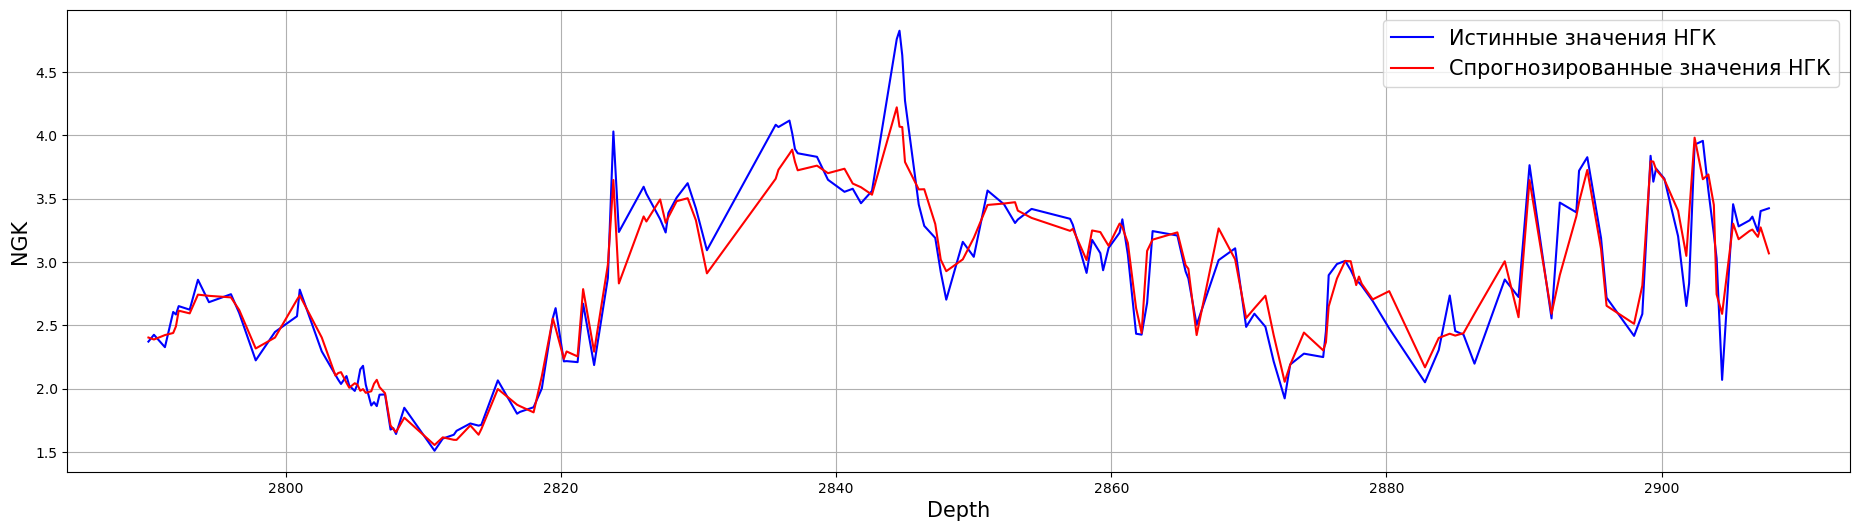

In [107]:
# Визуализируем предсказания с гиперпараметрами по optuna - значения НГК по глубине

import matplotlib.pyplot as plt

plt.figure(figsize=(23, 6))

plt.plot(depth_plotting, y_test_plotting, color = 'b', label = 'Истинные значения НГК')
plt.plot(depth_plotting, preds_plotting, c = 'r', label = 'Спрогнозированные значения НГК')

plt.xlabel('Depth', fontsize = 15)
plt.ylabel('NGK', fontsize = 15)

plt.legend(fontsize = 15)
plt.grid()
plt.show()

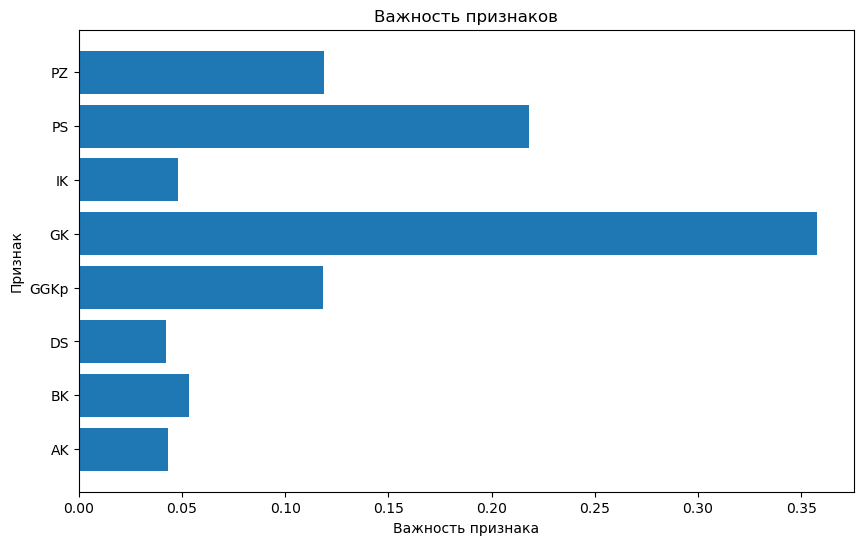

In [111]:
# Оценим важность признаков 

# Получение важности признаков
feature_importance = model_gb_optuna.feature_importances_

# Получение названий признаков
feature_names = names

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance, align='center')
plt.yticks(range(len(feature_importance)), feature_names)
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков')
plt.show()

Feature Selection

In [112]:
# Попробуем оставить только 4 самых важный признака - PZ, PS, GK, GGKp

X = df.drop(['NGK', 'AK', 'BK', 'DS', 'IK'], axis = 1)
y = df['NGK']

In [114]:
np.random.seed(42)

#Делим на тест и трейн первый раз - достанем тестовую глубину
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

# Берем глубину для визуализации предсказаний каротажа
depth = X_test.loc[:, 'Depth']
X = X.drop('Depth', axis=1)

#Делим на тест и трейн
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [115]:
def objective_GB_new(trial):
    
    max_depth = trial.suggest_int('max_depth', 2, 15, step = 3)
    n_estimators = trial.suggest_int('n_estimators', 10, 1000, 20)
    max_features = trial.suggest_categorical('max_features', [None, 'sqrt', 'log2'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log = True)
    
    score = cross_val_score(GradientBoostingRegressor(max_depth=max_depth, n_estimators=n_estimators,
                                                     max_features=max_features, learning_rate=learning_rate,
                                                     random_state=42),
                           X_train, y_train, cv=3, scoring='r2', n_jobs=-1).mean()
    return score

In [116]:
study_gb_new = optuna.create_study(direction='maximize')
study_gb_new.optimize(objective_GB_new, n_trials=30)
study_gb_new.best_params


[I 2024-04-10 21:48:07,518] A new study created in memory with name: no-name-9745192a-3b71-4fa0-838c-5ca7450a945d
/Users/aleksandrbogdanov/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [2, 15] and step=3, but the range is not divisible by `step`. It will be replaced by [2, 14].
  warnings.warn(
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_23100/3853963294.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int('n_estimators', 10, 1000, 20)
/Users/aleksandrbogdanov/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [10, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 990].
  warnings.warn(
[I 2024-04-10 21:48:08,977] Trial 0 finished with value: 0.264961982303979 and parameters: {'max_depth': 5, 'n

{'max_depth': 8,
 'n_estimators': 810,
 'max_features': 'sqrt',
 'learning_rate': 0.004365011571839921}

In [117]:
model_gb_optuna_new = GradientBoostingRegressor(**study_gb_new.best_params)
model_gb_optuna_new.fit(X_train, y_train)
preds_gb_optuna_new = model_gb_optuna_new.predict(X_test)
r2_score(y_test, preds_gb_optuna_new)

0.911981160994626

In [ ]:
# Качество уменьшилось совсем незначительно, хотя признаков осталось всего 4

,GGKp,GK,PS,PZ
538,2.481,5.464,112.100,21.11
523,2.544,5.559,110.754,17.11
235,2.385,4.002,34.020,28.56
524,2.584,6.201,112.624,17.98
486,2.260,6.625,117.111,9.37
...,...,...,...,...
421,2.553,7.719,124.029,7.30
382,2.562,6.742,122.982,6.92
519,2.480,7.540,115.952,15.56
404,2.651,6.670,123.132,6.18


In [119]:
# Отсортируем полученные значения по optuna для визуализации предсказаний

depth_values = depth.values.astype('float64')
y_test_for_plot = y_test.values.astype('float64')

plot_test_arr = list(zip(depth_values, y_test_for_plot))
plot_sorted_arr = sorted(plot_test_arr, key=lambda x: x[0])
depth_plotting = [i[0] for i in plot_sorted_arr]
y_test_plotting = [i[1] for i in plot_sorted_arr]
depth_plotting

[2790.0,
 2790.4,
 2791.2,
 2791.8,
 2792.0,
 2792.2,
 2793.0,
 2793.6,
 2794.4,
 2796.0,
 2796.6,
 2797.8,
 2799.2,
 2800.8,
 2801.0,
 2802.6,
 2803.6,
 2803.8,
 2804.0,
 2804.4,
 2804.6,
 2805.0,
 2805.2,
 2805.4,
 2805.6,
 2805.8,
 2806.2,
 2806.4,
 2806.6,
 2806.8,
 2807.2,
 2807.6,
 2807.8,
 2808.0,
 2808.6,
 2810.8,
 2811.4,
 2812.2,
 2812.4,
 2813.4,
 2814.0,
 2814.2,
 2815.4,
 2816.8,
 2817.0,
 2818.0,
 2818.6,
 2819.4,
 2819.6,
 2820.2,
 2820.4,
 2821.2,
 2821.6,
 2822.4,
 2823.4,
 2823.8,
 2824.2,
 2826.0,
 2826.2,
 2827.2,
 2827.6,
 2827.8,
 2828.4,
 2829.2,
 2829.8,
 2830.6,
 2835.6,
 2835.8,
 2836.6,
 2836.8,
 2837.0,
 2837.2,
 2838.6,
 2839.4,
 2840.6,
 2841.2,
 2841.8,
 2842.6,
 2844.4,
 2844.6,
 2844.8,
 2845.0,
 2846.0,
 2846.4,
 2847.2,
 2847.6,
 2848.0,
 2849.2,
 2850.0,
 2851.0,
 2852.2,
 2853.0,
 2853.2,
 2854.2,
 2857.0,
 2857.2,
 2858.2,
 2858.6,
 2859.2,
 2859.4,
 2859.8,
 2860.6,
 2860.8,
 2861.2,
 2861.8,
 2862.2,
 2862.6,
 2863.0,
 2864.8,
 2865.4,
 2865.6,
 

In [120]:
# Тут непосредственно предсказания

plot_preds_arr = list(zip(depth_values, preds_gb_optuna_new))
plot_sorted_preds = sorted(plot_preds_arr, key=lambda x: x[0])
depth_plotting = [i[0] for i in plot_sorted_preds]
preds_plotting = [i[1] for i in plot_sorted_preds]
depth_plotting

[2790.0,
 2790.4,
 2791.2,
 2791.8,
 2792.0,
 2792.2,
 2793.0,
 2793.6,
 2794.4,
 2796.0,
 2796.6,
 2797.8,
 2799.2,
 2800.8,
 2801.0,
 2802.6,
 2803.6,
 2803.8,
 2804.0,
 2804.4,
 2804.6,
 2805.0,
 2805.2,
 2805.4,
 2805.6,
 2805.8,
 2806.2,
 2806.4,
 2806.6,
 2806.8,
 2807.2,
 2807.6,
 2807.8,
 2808.0,
 2808.6,
 2810.8,
 2811.4,
 2812.2,
 2812.4,
 2813.4,
 2814.0,
 2814.2,
 2815.4,
 2816.8,
 2817.0,
 2818.0,
 2818.6,
 2819.4,
 2819.6,
 2820.2,
 2820.4,
 2821.2,
 2821.6,
 2822.4,
 2823.4,
 2823.8,
 2824.2,
 2826.0,
 2826.2,
 2827.2,
 2827.6,
 2827.8,
 2828.4,
 2829.2,
 2829.8,
 2830.6,
 2835.6,
 2835.8,
 2836.6,
 2836.8,
 2837.0,
 2837.2,
 2838.6,
 2839.4,
 2840.6,
 2841.2,
 2841.8,
 2842.6,
 2844.4,
 2844.6,
 2844.8,
 2845.0,
 2846.0,
 2846.4,
 2847.2,
 2847.6,
 2848.0,
 2849.2,
 2850.0,
 2851.0,
 2852.2,
 2853.0,
 2853.2,
 2854.2,
 2857.0,
 2857.2,
 2858.2,
 2858.6,
 2859.2,
 2859.4,
 2859.8,
 2860.6,
 2860.8,
 2861.2,
 2861.8,
 2862.2,
 2862.6,
 2863.0,
 2864.8,
 2865.4,
 2865.6,
 

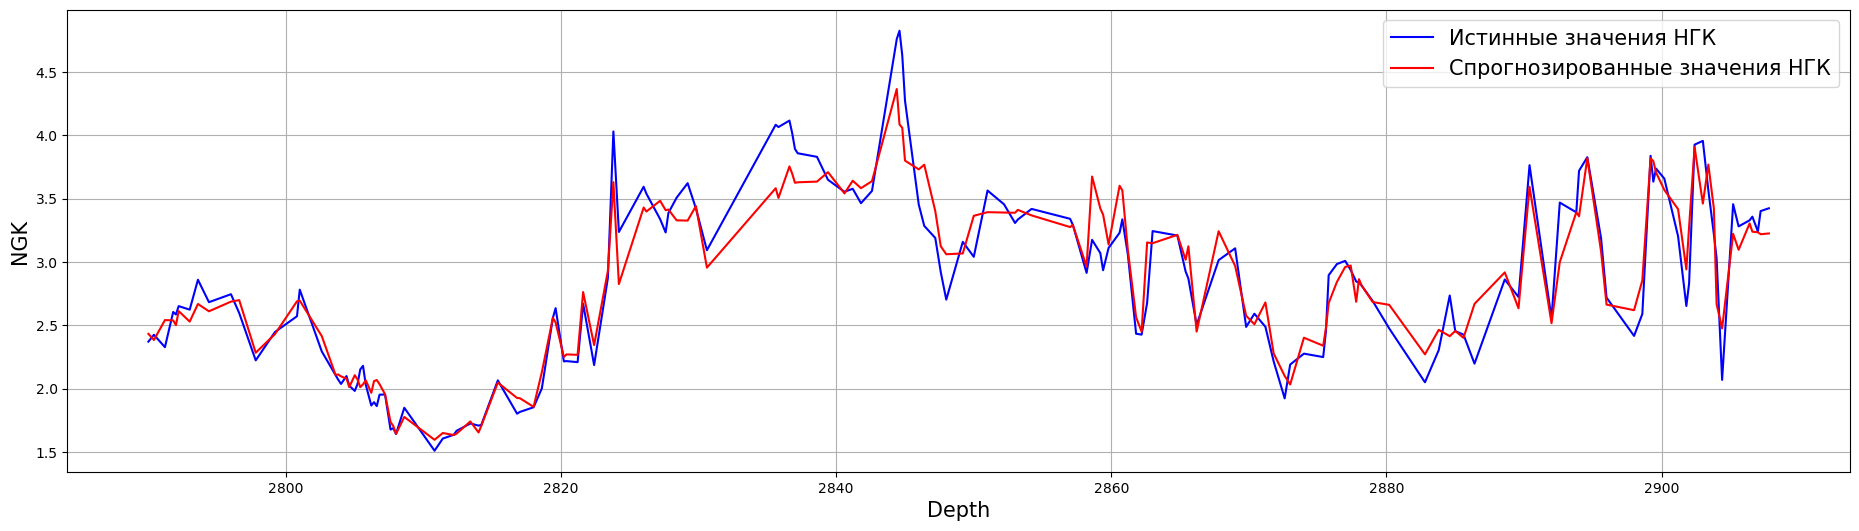

In [121]:
# Визуализируем предсказания с гиперпараметрами по optuna - значения НГК по глубине

import matplotlib.pyplot as plt

plt.figure(figsize=(23, 6))

plt.plot(depth_plotting, y_test_plotting, color = 'b', label = 'Истинные значения НГК')
plt.plot(depth_plotting, preds_plotting, c = 'r', label = 'Спрогнозированные значения НГК')

plt.xlabel('Depth', fontsize = 15)
plt.ylabel('NGK', fontsize = 15)

plt.legend(fontsize = 15)
plt.grid()
plt.show()

Попробуем улучшить предсказания, возьмем в качестве модели XGBoost

In [ ]:
# Catboost и LGBM брать не будем, качество будет примерно одинаковое + нет категориальных признаков

In [125]:
def objective_XGB(trial):
    
    max_depth = trial.suggest_int('max_depth', 2, 15, step = 3)
    n_estimators = trial.suggest_int('n_estimators', 10, 1000, 20)
    max_leaves = trial.suggest_int('max_leaves', 1, 15)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log = True)
    
    score = cross_val_score(XGBRegressor(max_depth=max_depth, n_estimators=n_estimators,
                                                     max_leaves = max_leaves, learning_rate=learning_rate,
                                                     random_state=42),
                           X_train, y_train, cv=3, scoring='r2', n_jobs=-1).mean()
    return score

In [126]:
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_XGB, n_trials=30)
study_xgb.best_params


[I 2024-04-10 21:55:18,785] A new study created in memory with name: no-name-0ca9ca93-34e0-4e66-8dcc-5db0b79c9b4b
/Users/aleksandrbogdanov/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [2, 15] and step=3, but the range is not divisible by `step`. It will be replaced by [2, 14].
  warnings.warn(
/var/folders/46/4js24d154nb0rgs9sp2kxk180000gn/T/ipykernel_23100/3944823240.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int('n_estimators', 10, 1000, 20)
/Users/aleksandrbogdanov/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [10, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 990].
  warnings.warn(
[I 2024-04-10 21:55:20,137] Trial 0 finished with value: 0.11105894715660085 and parameters: {'max_depth': 14,

{'max_depth': 11,
 'n_estimators': 650,
 'max_leaves': 10,
 'learning_rate': 0.021750371407334608}

In [127]:
model_xgb_optuna = XGBRegressor(**study_xgb.best_params)
model_xgb_optuna.fit(X_train, y_train)
preds_xgb = model_xgb_optuna.predict(X_test)
r2_score(y_test, preds_xgb)

0.9052864997894976

In [ ]:
# Качество уменьшилось, оставим GBRegressor в качестве модели